In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# Make tensorflow not take over the entire GPU memory
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
from tfga import GeometricAlgebra
from tfga.layers import GeometricProductDense, TensorToGeometric, GeometricToTensor

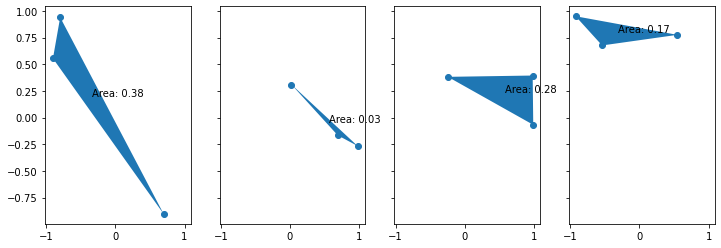

In [2]:
def make_batch(batch_size):
    triangle_points = tf.random.uniform([batch_size, 3, 2], minval=-1, maxval=1, seed=0)
    x, y = triangle_points[..., 0], triangle_points[..., 1]
    ax, ay, bx, by, cx, cy = x[..., 0], y[..., 0], x[..., 1], y[..., 1], x[..., 2], y[..., 2]
    triangle_areas = 0.5 * tf.abs(ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    return triangle_points, triangle_areas

num_samples = 4
sample_points, sample_areas = make_batch(num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
fig.show()

In [3]:
ga = GeometricAlgebra([1, 1])
s_indices = [0]
v_indices = [1, 2]
mv_indices = tf.range(ga.num_blades)

model = tf.keras.Sequential([
    TensorToGeometric(ga, blade_indices=v_indices),
    GeometricProductDense(
        ga, units=64, activation="relu",
        blade_indices_kernel=mv_indices,
        blade_indices_bias=mv_indices,
    ),
    GeometricProductDense(
        ga, units=64, activation="relu",
        blade_indices_kernel=mv_indices,
        blade_indices_bias=mv_indices,
    ),
    GeometricProductDense(
        ga, units=1,
        blade_indices_kernel=mv_indices,
        blade_indices_bias=s_indices,
    ),
    GeometricToTensor(ga, blade_indices=s_indices)
])

# [B, 3, 2]

print("Samples:", sample_points)
print("Model(Samples):", model(sample_points))

Samples: tf.Tensor(
[[[-0.79827476  0.9403336 ]
  [ 0.69752836 -0.9034374 ]
  [-0.90295386  0.5549493 ]]

 [[ 0.688936   -0.16585016]
  [ 0.01991677  0.31040502]
  [ 0.97630143 -0.26602125]]

 [[-0.24420428  0.3823743 ]
  [ 0.9908879  -0.06757498]
  [ 0.9824078   0.39463305]]

 [[ 0.54828143  0.7763324 ]
  [-0.92291665  0.9507897 ]
  [-0.5395093   0.67681694]]], shape=(4, 3, 2), dtype=float32)
Model(Samples): tf.Tensor(
[[[-0.12212075]]

 [[-0.03243198]]

 [[-0.03031765]]

 [[-0.07880722]]], shape=(4, 1, 1), dtype=float32)


In [4]:
train_points, train_areas = make_batch(1024)
test_points, test_areas = make_batch(128)

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model.fit(x=train_points, y=train_areas, validation_data=(test_points, test_areas), epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0602 - mae: 0.1894 - val_loss: 0.0351 - val_mae: 0.1399
Epoch 2/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0370 - mae: 0.1483 - val_loss: 0.0303 - val_mae: 0.1283
Epoch 3/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0308 - mae: 0.1349 - val_loss: 0.0259 - val_mae: 0.1186
Epoch 4/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0285 - mae: 0.1294 - val_loss: 0.0226 - val_mae: 0.1150
Epoch 5/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0265 - mae: 0.1265 - val_loss: 0.0214 - val_mae: 0.1087
Epoch 6/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0201 - mae: 0.1101 - val_loss: 0.0196 - val_mae: 0.1002
Epoch 7/100
32/32 [==============================] - 1s 42ms/step - loss: 0.0178 - mae: 0.1035 - val_loss: 0.0166 - val_mae: 0.0935
Epoch 8/100
32/32 [==============================] - 1s 42ms/step - loss: 0.

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor_to_geometric (TensorT multiple                  0         
_________________________________________________________________
geometric_product_dense (Geo (4, 64, 4)                1024      
_________________________________________________________________
geometric_product_dense_1 (G (4, 64, 4)                16640     
_________________________________________________________________
geometric_product_dense_2 (G (4, 1, 4)                 257       
_________________________________________________________________
geometric_to_tensor (Geometr (4, 1, 1)                 0         
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________
None


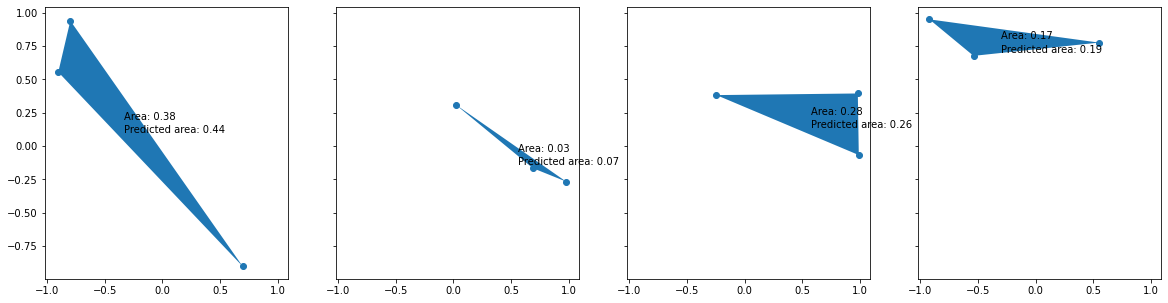

In [8]:
predicted_sample_areas = model(sample_points)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + tf.constant([0, -0.1]))
fig.show()

In [20]:
model_normal = tf.keras.Sequential([
    tf.keras.layers.Dense(64*2, activation="relu"),
    tf.keras.layers.Dense(64*2, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_normal.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model_normal.fit(x=tf.reshape(train_points, [-1, 6]), y=train_areas, validation_data=(tf.reshape(test_points, [-1, 6]), test_areas), epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0614 - mae: 0.1931 - val_loss: 0.0350 - val_mae: 0.1435
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0378 - mae: 0.1487 - val_loss: 0.0308 - val_mae: 0.1298
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0327 - mae: 0.1391 - val_loss: 0.0253 - val_mae: 0.1174
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0278 - mae: 0.1292 - val_loss: 0.0291 - val_mae: 0.1276
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0249 - mae: 0.1219 - val_loss: 0.0198 - val_mae: 0.1033
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0211 - mae: 0.1111 - val_loss: 0.0183 - val_mae: 0.0987
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0174 - mae: 0.1016 - val_loss: 0.0160 - val_mae: 0.0925
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0149 - m

In [21]:
print(model_normal.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (32, 128)                 896       
_________________________________________________________________
dense_13 (Dense)             (32, 128)                 16512     
_________________________________________________________________
dense_14 (Dense)             (32, 1)                   129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________
None


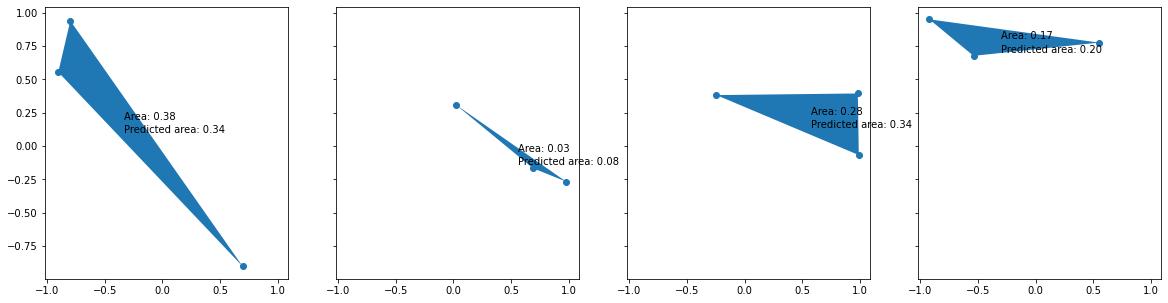

In [22]:
predicted_sample_areas = model_normal(tf.reshape(sample_points, [-1, 6]))

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + tf.constant([0, -0.1]))
fig.show()